In [1]:
import cvxpy as cp
import numpy as np
import scipy as sp
import scipy.io as io
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import trefide as tfd

# Load Data 

In [2]:
# Load data
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape

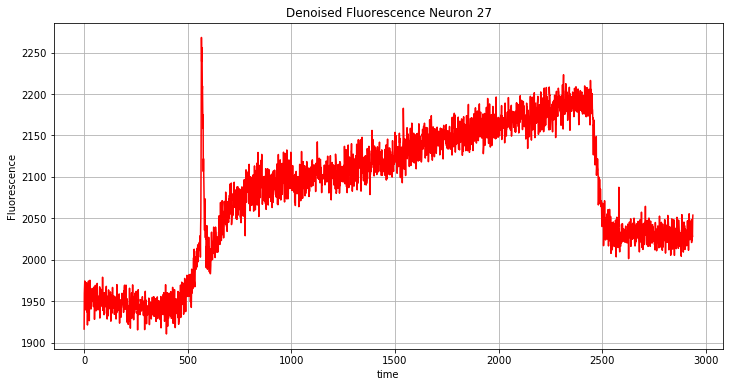

In [3]:
idx = np.random.randint(0, N)
idx = 27
signal = data['C'][idx,:]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T),signal, 'r')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Denoised Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Estimation Of Noise From Different Regions

In [4]:
fs = 10000.0
cutoff = 100
order = 6
min_pnr = 5
noise_factor = 3
estimator='pwelch'
summarize='logmexp'

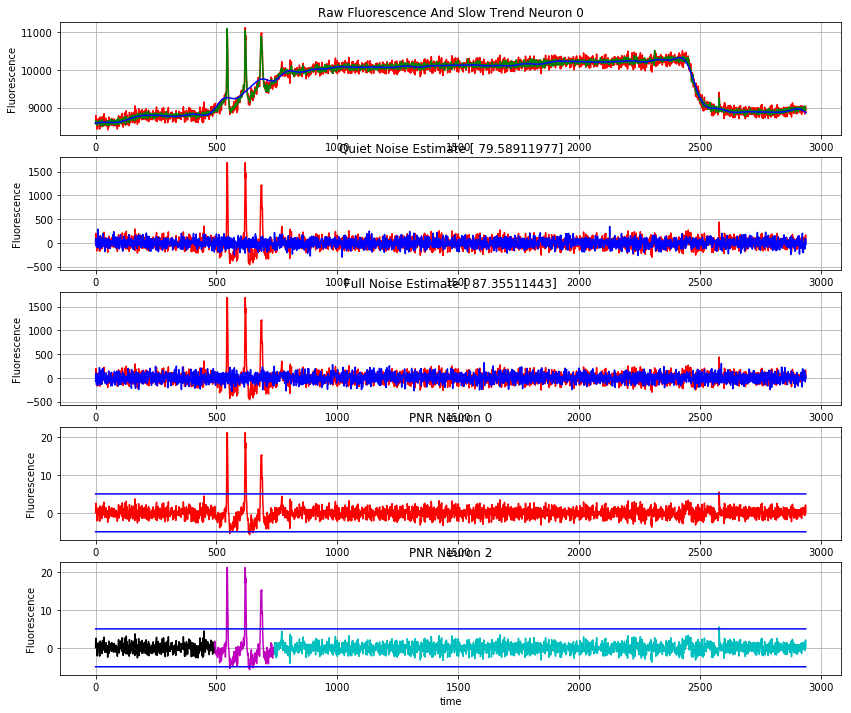

In [5]:
# Assign New Neuron At Random
idx = np.random.randint(0, N)
signal = data['C'][idx,:]
truth = signal.copy()


# Estimate Noise From Quiet Region
sigma = tfd.estimate_noise(np.array([signal[1500:2200]]),
                           estimator=estimator,
                           summarize=summarize)

# Add Artificial Noise and Re-estimate Noise
signal = signal + np.random.randn(T) * np.sqrt(noise_factor**2 - 1)*sigma
highpass_signal = tfd.butter_highpass_filter(signal, cutoff, fs, order)
sigma = tfd.estimate_noise(np.array([signal[1500:2200]]),
                           estimator=estimator,
                           summarize=summarize)
sigma_full = tfd.estimate_noise(np.array([signal]),
                           estimator=estimator,
                           summarize=summarize)


region_idx, is_active = tfd.detect_regions(signal)
colors = ['k', 'm', 'c', 'g', 'y']


# Generate Comparison Plots
fig, ax = plt.subplots(5, figsize=(14, 12))
ax[0].plot(np.arange(T),signal, 'r')
ax[0].plot(np.arange(T), truth, 'g')
ax[0].plot(np.arange(T),signal - highpass_signal, 'b')

ax[0].set(xlabel='time', ylabel='Fluorescence',
       title='Raw Fluorescence And Slow Trend Neuron {}'.format(idx))
ax[0].grid()


ax[1].plot(np.arange(T), highpass_signal, 'r')
ax[1].plot(np.arange(T), np.random.randn(T)*sigma, 'b')

ax[1].set(xlabel='time', ylabel='Fluorescence',
       title='Quiet Noise Estimate {}'.format(sigma))
ax[1].grid()

ax[2].plot(np.arange(T), highpass_signal, 'r')
ax[2].plot(np.arange(T), np.random.randn(T)*sigma_full, 'b')

ax[2].set(xlabel='time', ylabel='Fluorescence',
       title='Full Noise Estimate {}'.format(sigma_full))
ax[2].grid()

ax[3].plot(np.arange(T), highpass_signal/sigma, 'r')
ax[3].plot(np.arange(T), np.ones(T)*min_pnr, 'b')
ax[3].plot(np.arange(T), np.ones(T)*-min_pnr, 'b')

ax[3].set(xlabel='time', ylabel='Fluorescence',
       title='PNR Neuron {}'.format(idx))
ax[3].grid()

for idx, rdx in enumerate(region_idx):
    ax[4].plot(np.arange(len(rdx)) + min(rdx), (highpass_signal/sigma)[rdx], colors[idx])
ax[4].plot(np.arange(T), np.ones(T)*min_pnr, 'b')
ax[4].plot(np.arange(T), np.ones(T)*-min_pnr, 'b')

ax[4].set(xlabel='time', ylabel='Fluorescence',
       title='PNR Neuron {}'.format(idx))
ax[4].grid()
plt.show()

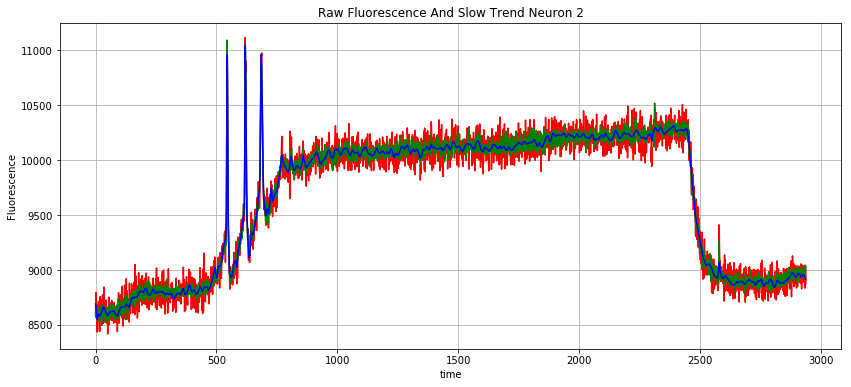

In [6]:
trend_filtered, lambdas = tfd.constrained_l1tf(
    signal, noise_summarizer='logmexp', noise_estimator='pwelch',
    region_active_discount=.1)

fig, ax = plt.subplots(1, figsize=(14, 6))
ax.plot(np.arange(T), signal, 'r')
ax.plot(np.arange(T), truth, 'g')
ax.plot(np.arange(T), trend_filtered, 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Raw Fluorescence And Slow Trend Neuron {}'.format(idx))
ax.grid()
plt.show()

In [7]:
# Add noise to traces
data['noisey'] = np.zeros(data['C'].shape)
for idx, stdv in enumerate(tfd.estimate_noise(data['C'])):
    data['noisey'][idx,:] = data['C'][idx,:] + np.random.randn(T) * np.sqrt(noise_factor**2 - 1)*stdv

In [8]:
denoised = tfd.denoise(data['noisey'], region_active_discount=.05)

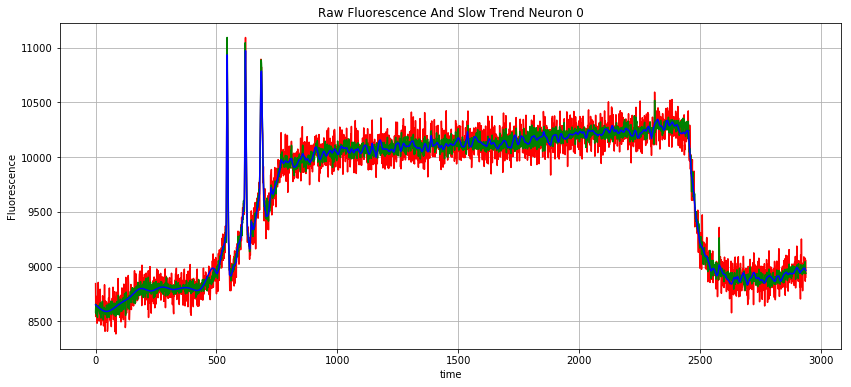

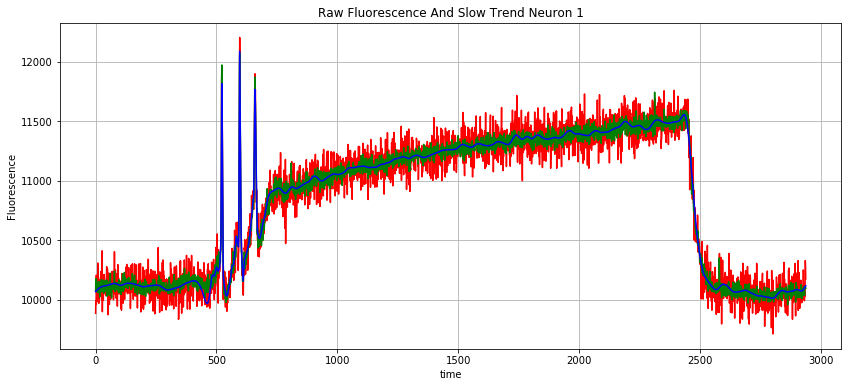

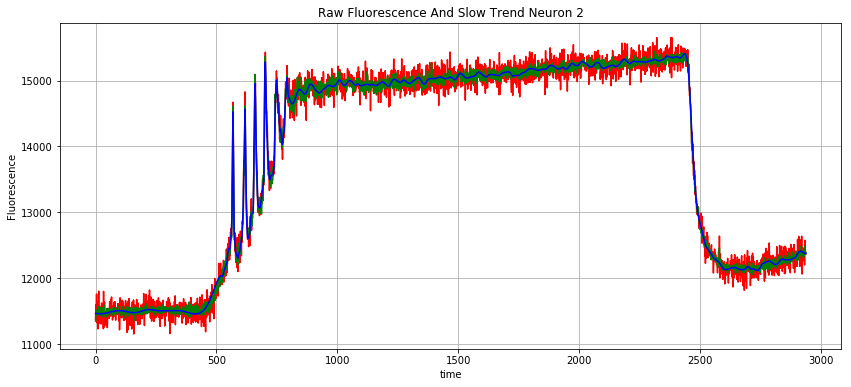

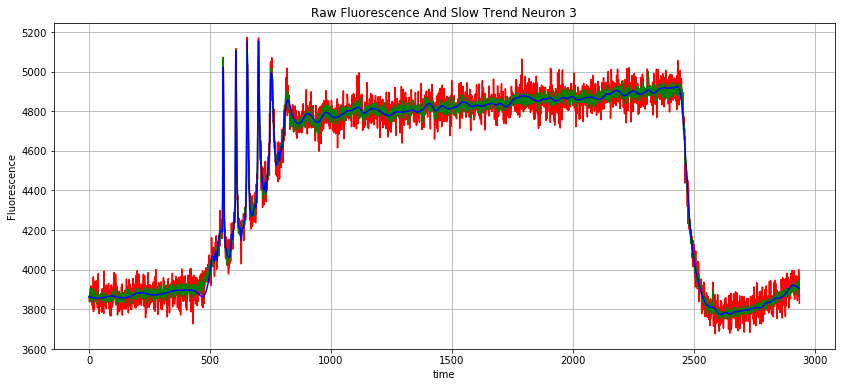

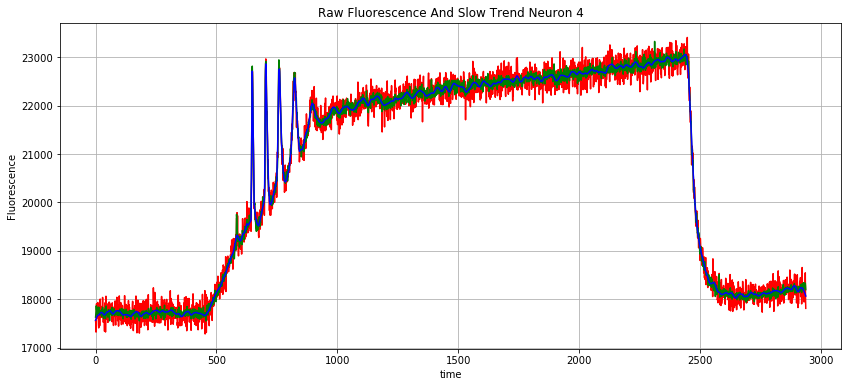

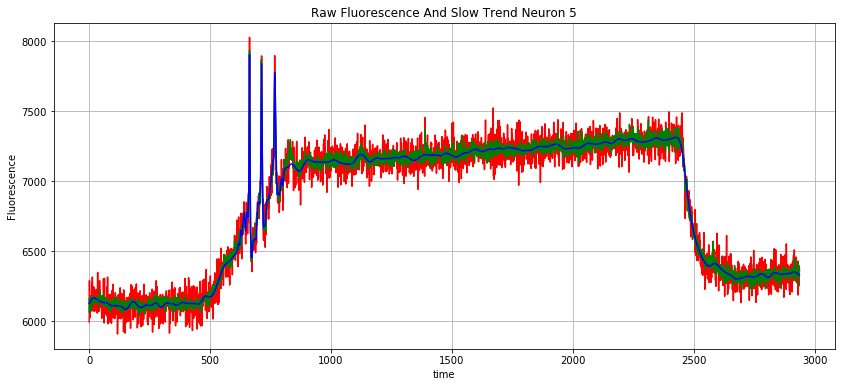

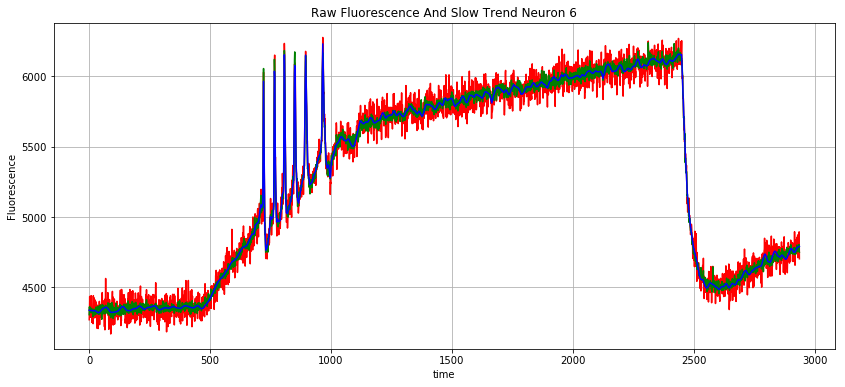

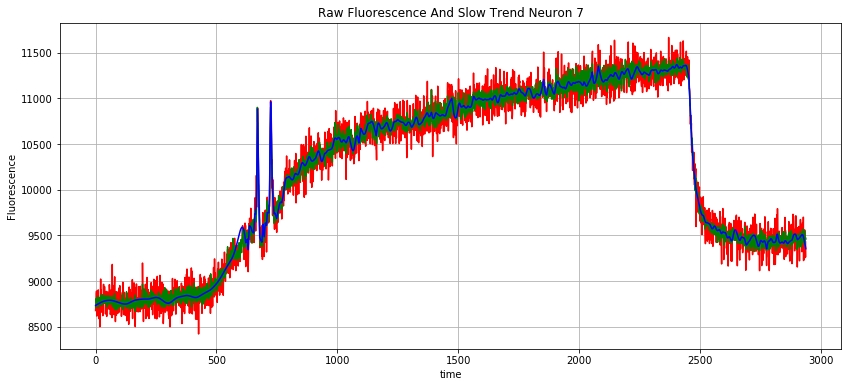

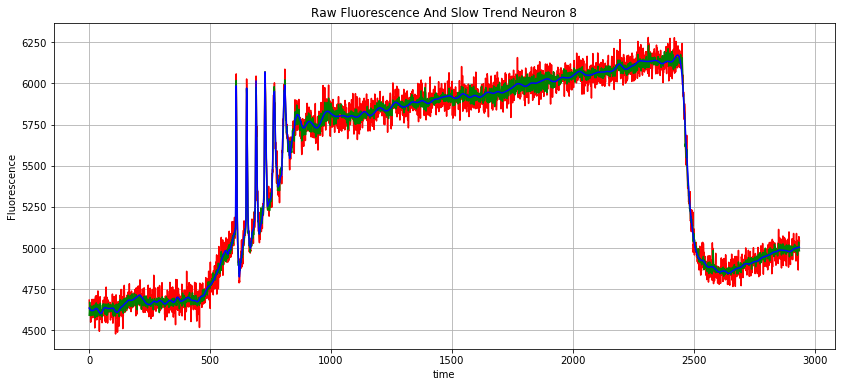

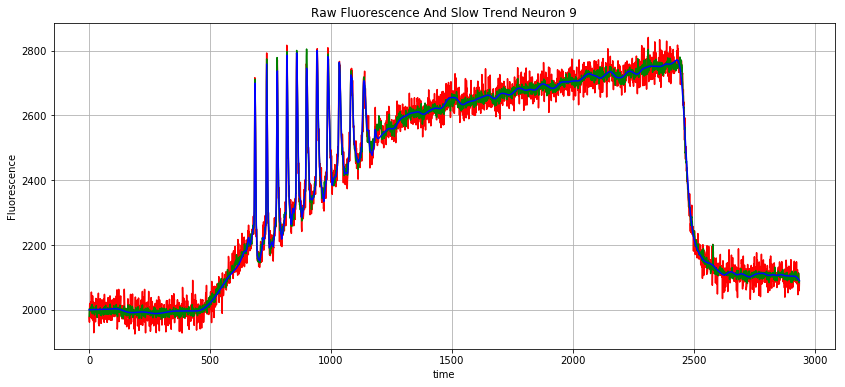

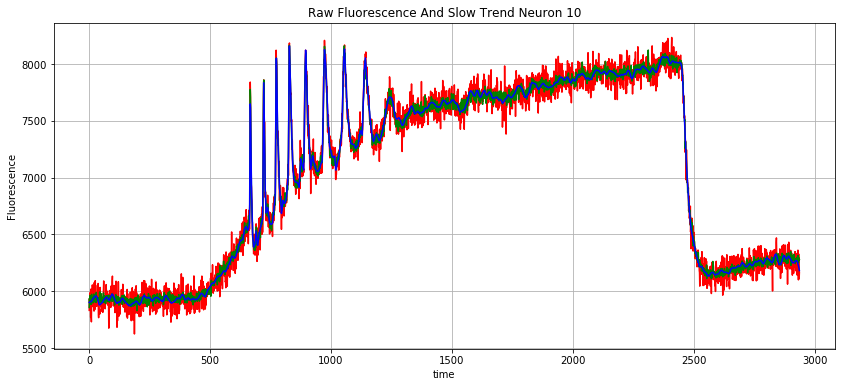

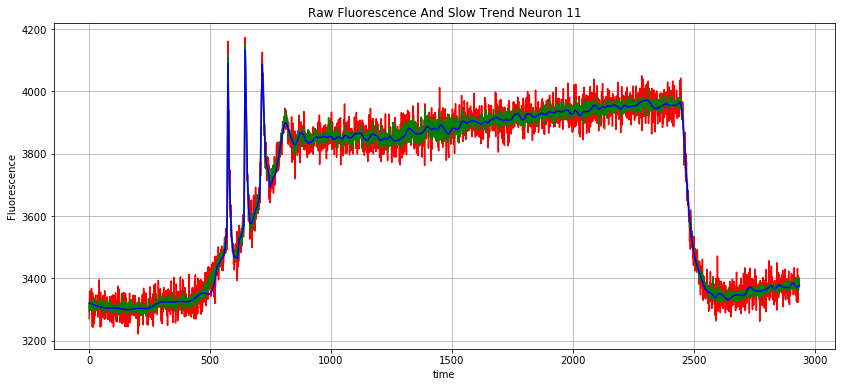

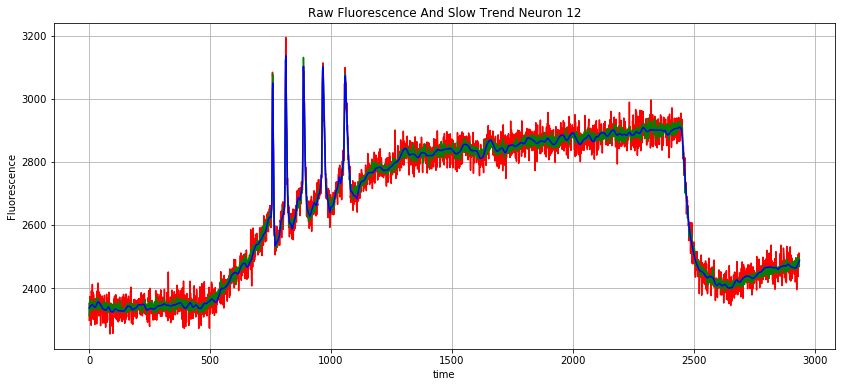

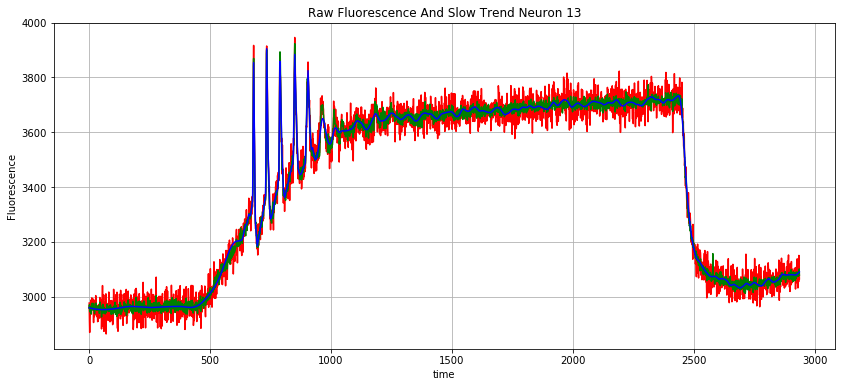

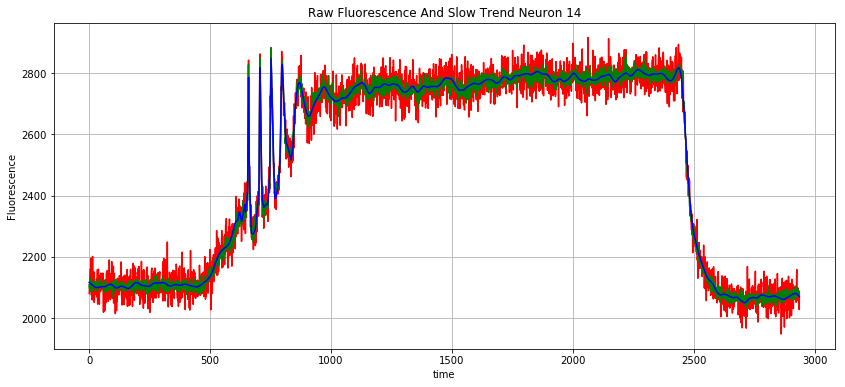

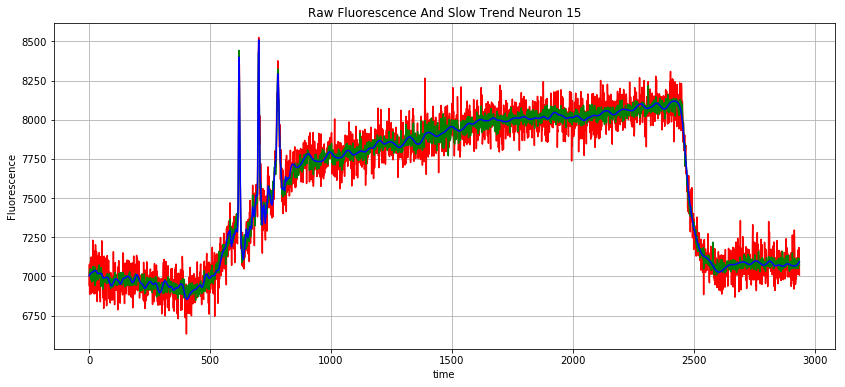

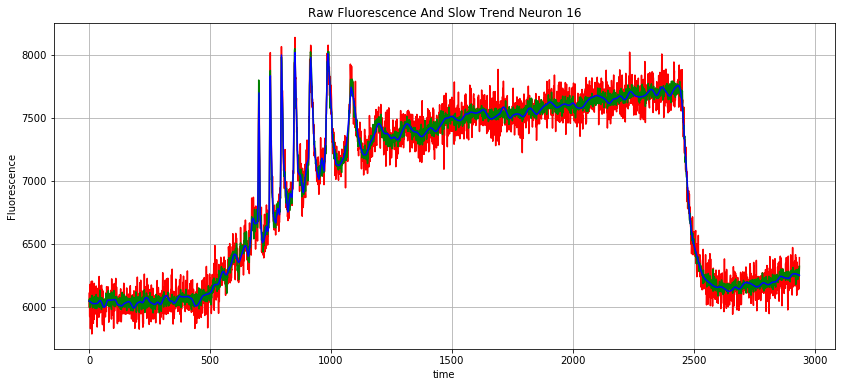

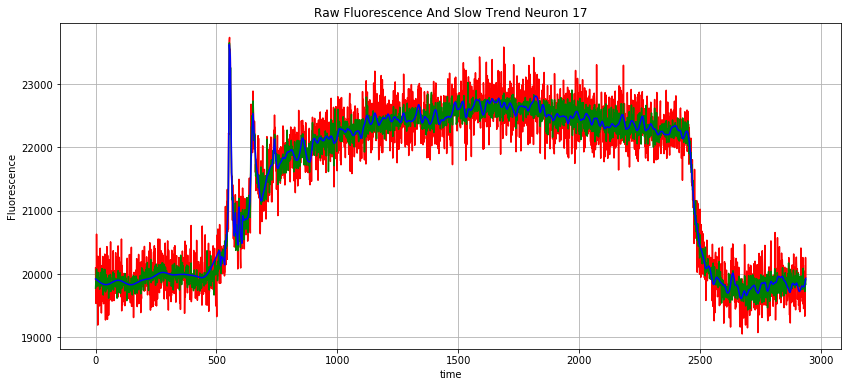

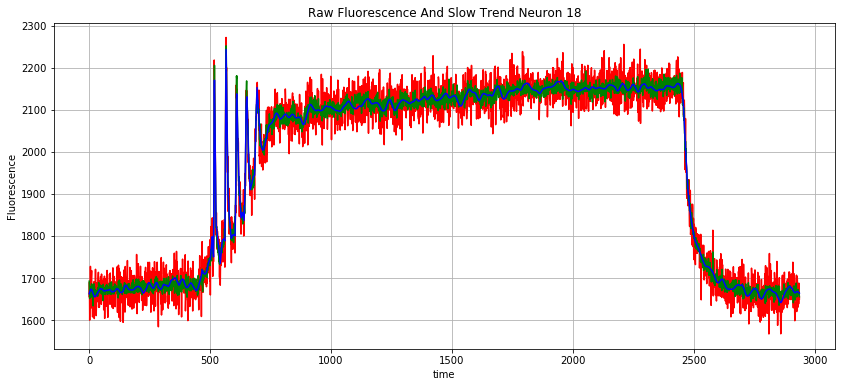

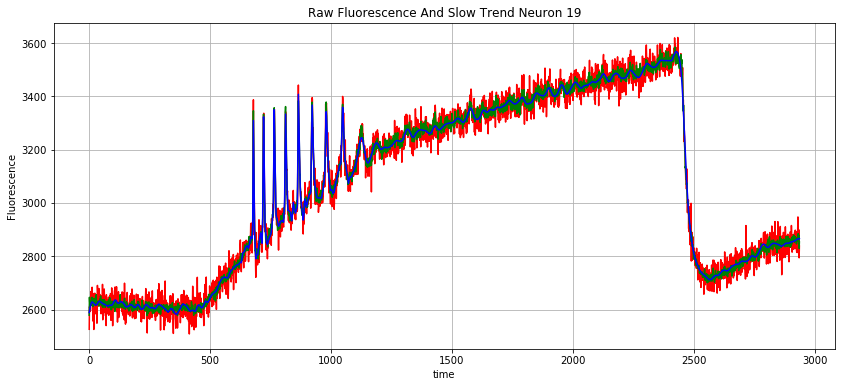

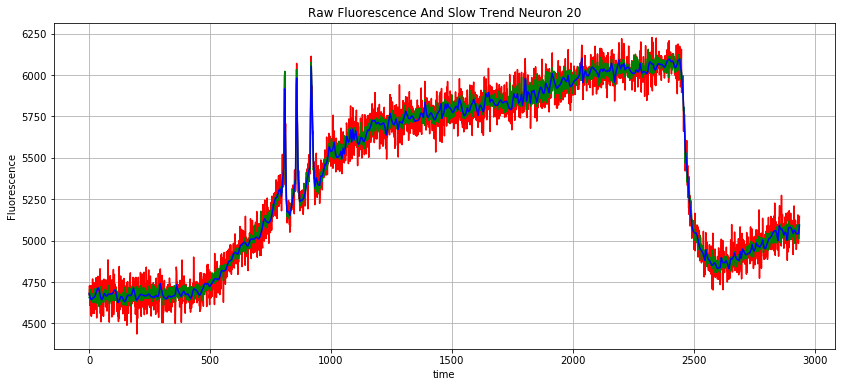

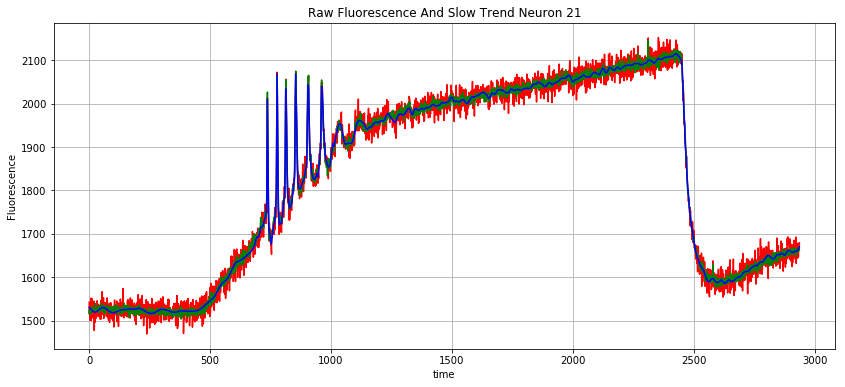

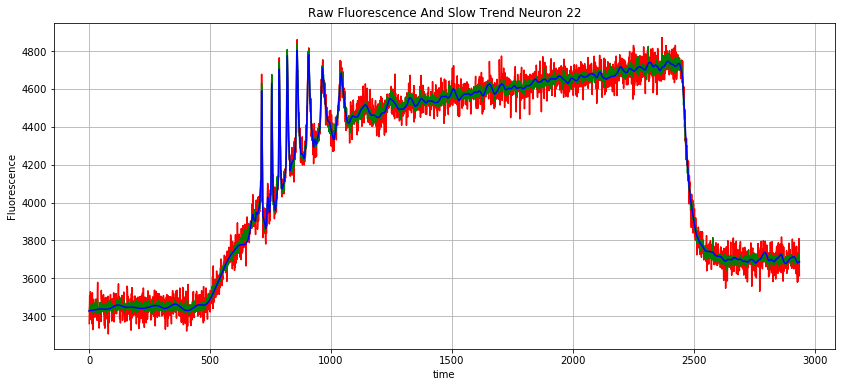

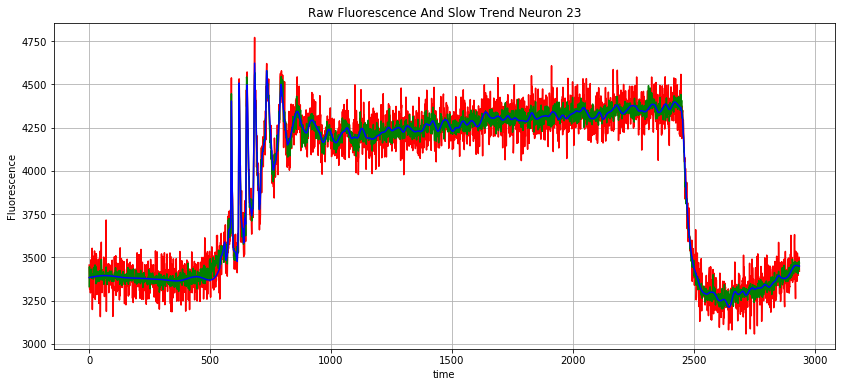

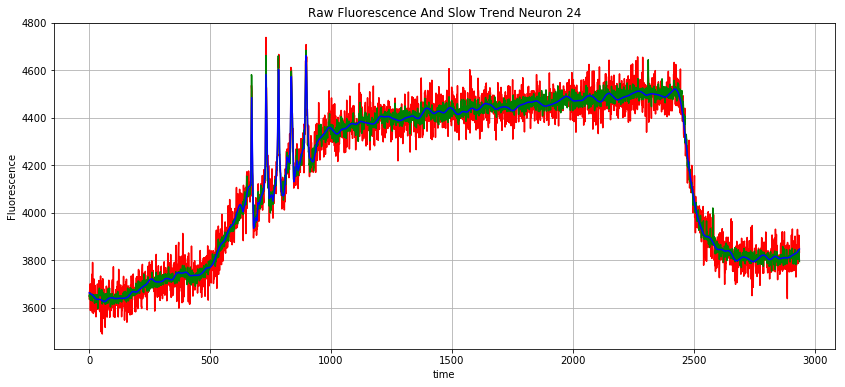

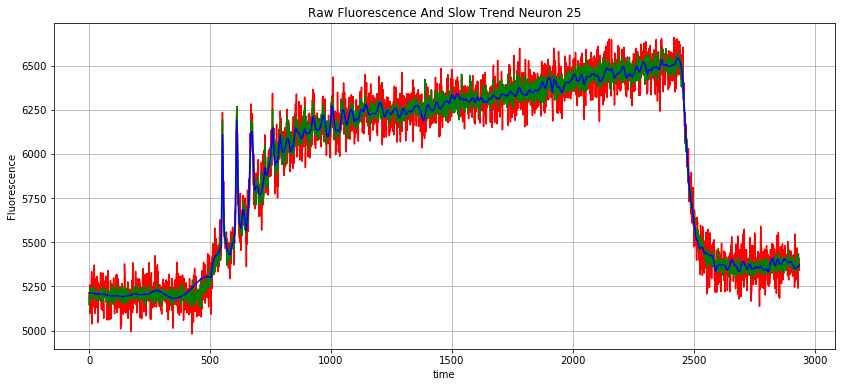

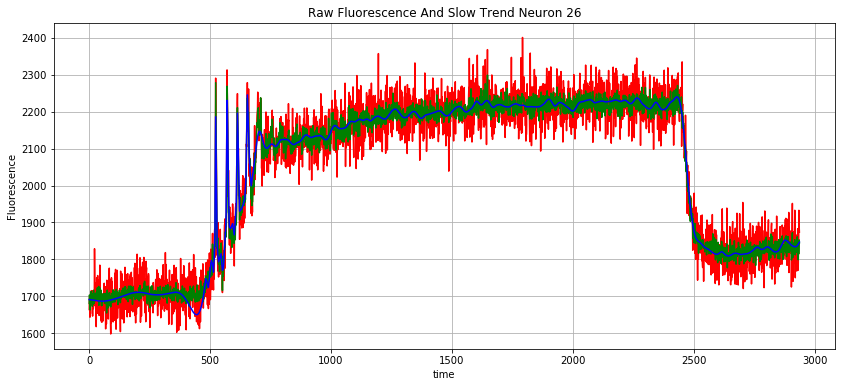

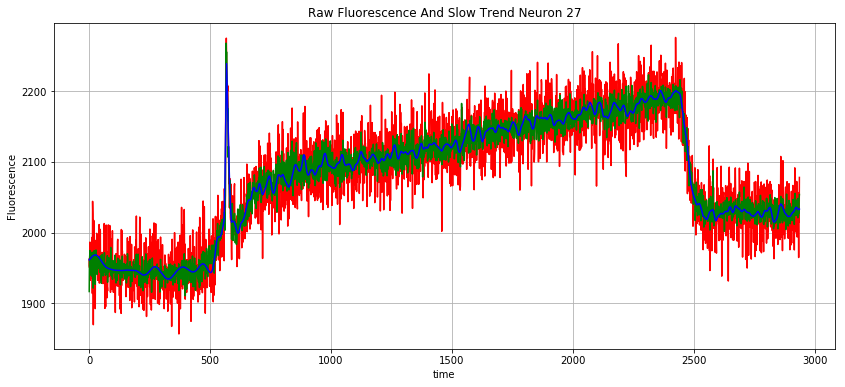

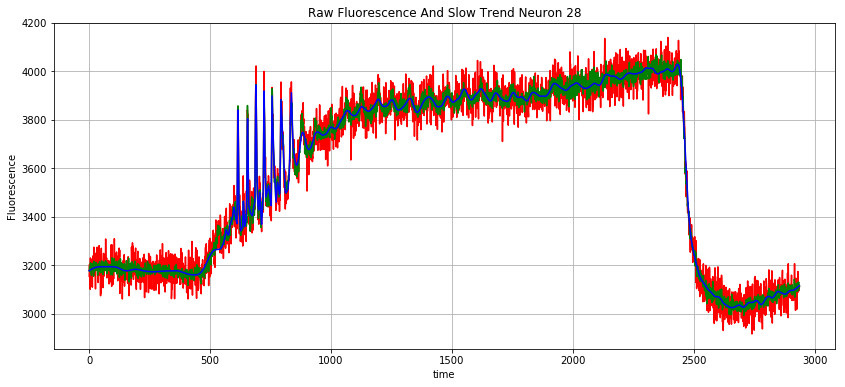

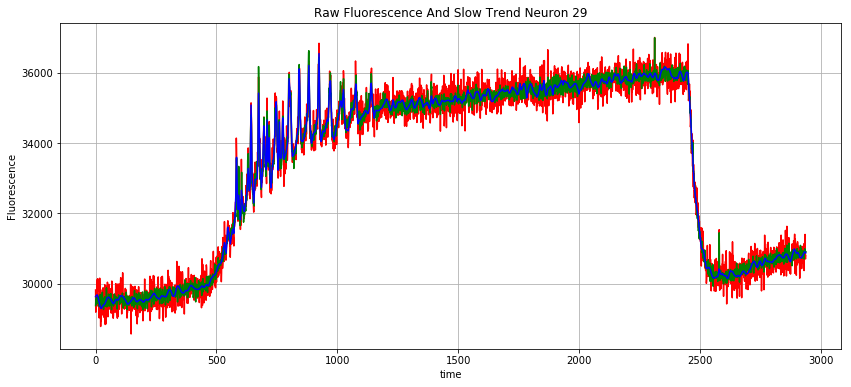

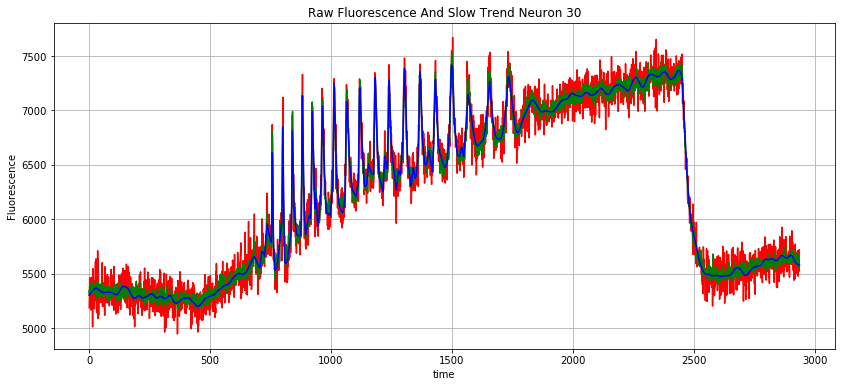

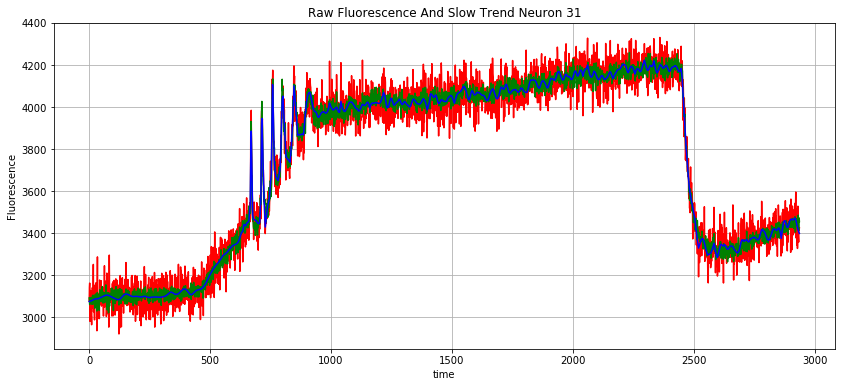

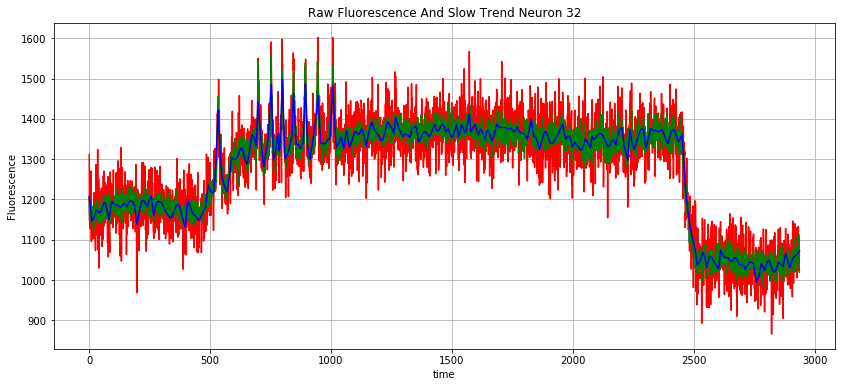

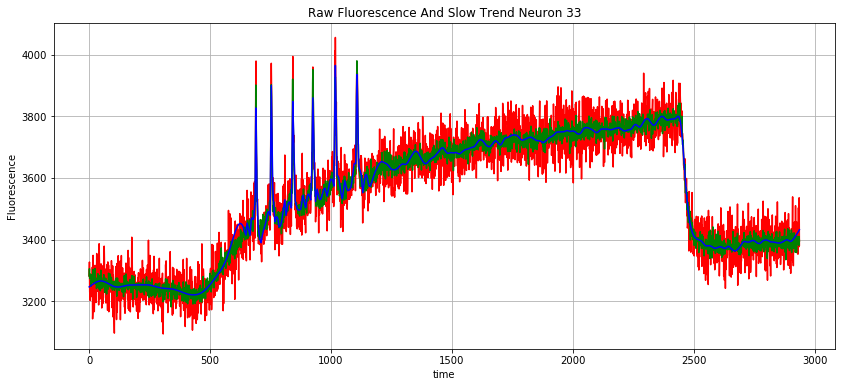

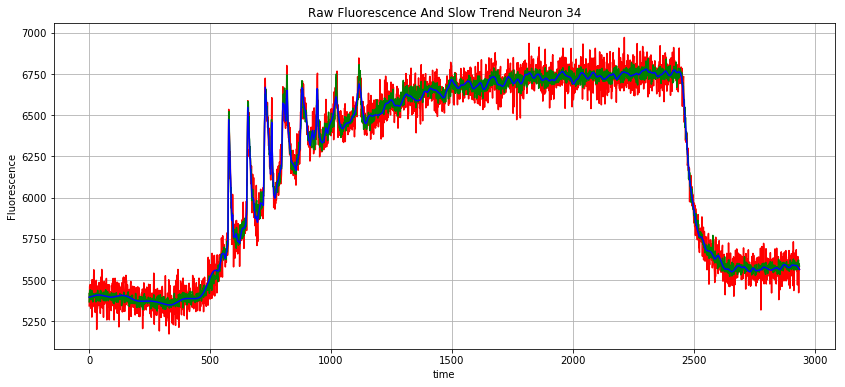

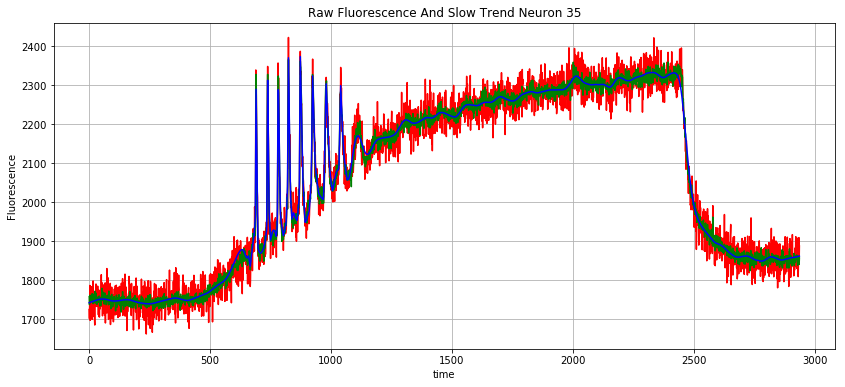

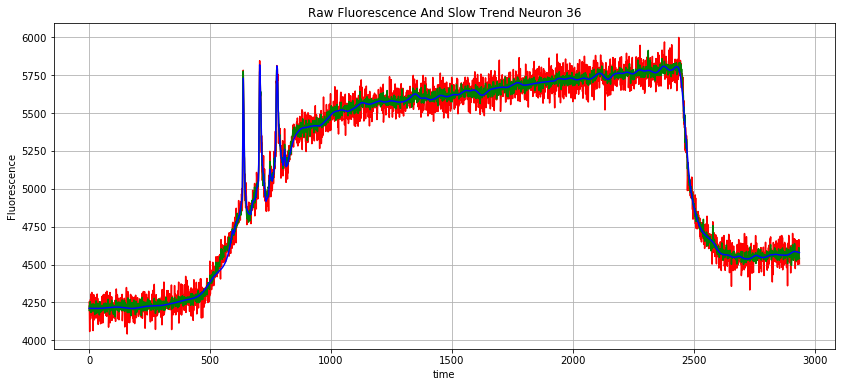

In [9]:
for idx in np.arange(N):
    
    fig, ax = plt.subplots(1, figsize=(14, 6))
    ax.plot(np.arange(T), data['noisey'][idx,:], 'r')
    ax.plot(np.arange(T), data['C'][idx,:], 'g')
    ax.plot(np.arange(T), denoised[idx,:], 'b')

    ax.set(xlabel='time', ylabel='Fluorescence',
           title='Raw Fluorescence And Slow Trend Neuron {}'.format(idx))
    ax.grid()
    plt.show()